In [13]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlmodel import Session, select

from rs_graph.db import models as db_models
from rs_graph.db.utils import get_engine

plt.style.use("opinionated_rc")

annotations = pd.read_csv("../annotated-random-sample-prelinked-sources.csv")
print(len(annotations))

# Drop any rows with nans
annotations = annotations.dropna(subset=["label-match"])
print(len(annotations))

annotations.sample(3)

150
146


,source,paper_doi,paper_doi_url,repo_url,label-match,label-repo-type,label-repo-sub-type,notes,help
142,pwc,10.48550/arxiv.2002.12738,https://doi.org/10.48550/arxiv.2002.12738,https://github.com/m-hasan-n/hlp,match,analysis-and-modeling,inactive,NaN,NaN
13,joss,10.21105/joss.06370,https://doi.org/10.21105/joss.06370,https://github.com/kennethenevoldsen/augmenty,match,infrastructure,active,NaN,NaN
14,joss,10.21105/joss.03968,https://doi.org/10.21105/joss.03968,https://github.com/qiskit/rustworkx,match,infrastructure,active,NaN,NaN


In [14]:
# Percent of "label-match" by source
annotations.groupby("source")["label-match"].value_counts() / annotations.groupby(
    "source"
)["label-match"].count() * 100

source  label-match
joss    match          100.000000
plos    match           96.000000
        no-match         4.000000
pwc     match           93.478261
        no-match         6.521739
dtype: float64

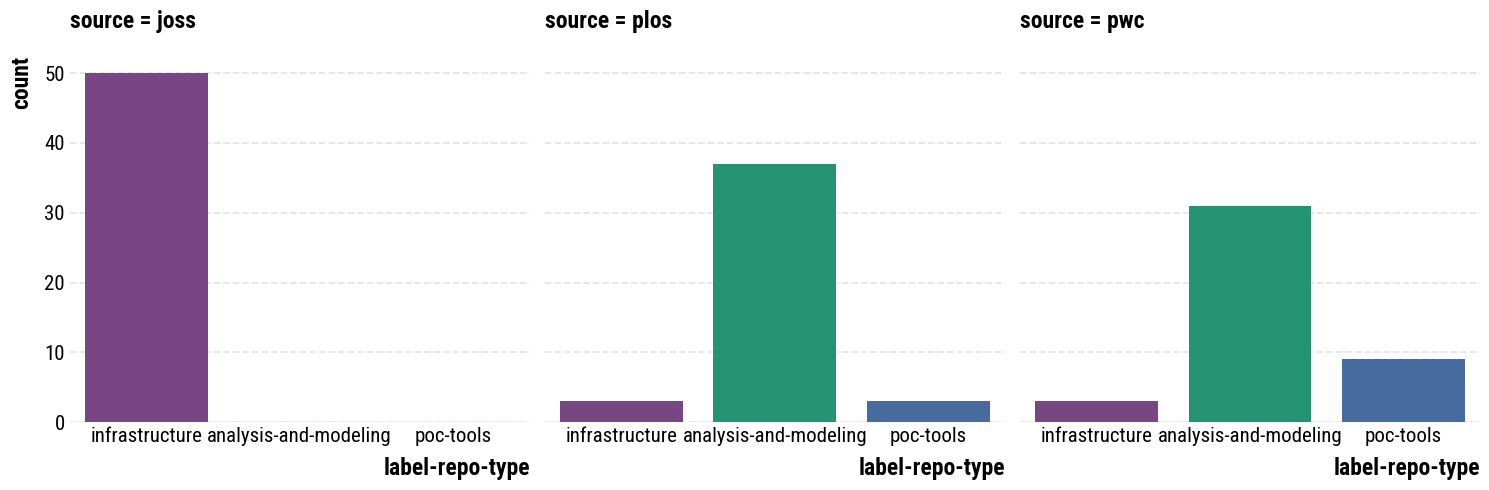

In [21]:
# Drop "data" (label-repo-type) repos and then countplot of "label-repo-type" by source
no_data_annotations = annotations[annotations["label-repo-type"] != "data"]
sns.catplot(
    data=no_data_annotations,
    x="label-repo-type",
    hue="label-repo-type",
    col="source",
    palette=cmaps.bold._colors[
        : no_data_annotations["label-repo-type"].nunique()
    ].tolist(),
    kind="count",
)

In [22]:
# get a dataset of linked repos and papers
data = []
engine = get_engine(prod=True)
with Session(engine) as session:
    statement = (
        select(
            db_models.DocumentRepositoryLink,
            db_models.Document,
            db_models.Repository,
        )
        .join(
            db_models.Document,
        )
        .join(
            db_models.Repository,
        )
        .where(
            db_models.DocumentRepositoryLink.dataset_source_id == 3,
        )
    )

    # For each one, we need to get count of contributors for document and repository
    for link, document, repository in session.exec(statement):
        # Also keep track of how many of each type by position their are
        # i.e. how many first authors are matched to devs,
        # how many middle authors are matched to devs, etc.

        # Create and exec doc statement
        doc_contrib_statement = select(db_models.DocumentContributor).where(
            db_models.DocumentContributor.document_id == document.id
        )
        doc_contribs = list(session.exec(doc_contrib_statement))
        doc_contribs_lut = {contrib.id: contrib for contrib in doc_contribs}

        # Create and exec repo statement
        repo_contrib_statement = select(db_models.RepositoryContributor).where(
            db_models.RepositoryContributor.repository_id == repository.id
        )
        repo_contribs = list(session.exec(repo_contrib_statement))
        repo_contribs_lut = {contrib.id: contrib for contrib in repo_contribs}

        # For each doc contrib, check if linked to repo contrib
        matched_contribs_by_position = {}
        for doc_contrib in doc_contribs:
            for repo_contrib in repo_contribs:
                this_doc_contrib_repo_contribs_statement = (
                    select(db_models.ResearcherDeveloperAccountLink)
                    .where(
                        db_models.ResearcherDeveloperAccountLink.researcher_id
                        == doc_contrib.researcher_id
                    )
                    .where(
                        db_models.ResearcherDeveloperAccountLink.developer_account_id
                        == repo_contrib.developer_account_id
                    )
                )
                matched_contrib = session.exec(
                    this_doc_contrib_repo_contribs_statement
                ).first()
                if matched_contrib:
                    position = doc_contrib.position
                    if position not in matched_contribs_by_position:
                        matched_contribs_by_position[position] = []
                    matched_contribs_by_position[position].append(matched_contrib)

        # Calc all n_contribs
        n_doc_contributors = len(doc_contribs)
        n_repo_contributors = len(repo_contribs)
        n_matched_contributors = sum(
            [len(v) for v in matched_contribs_by_position.values()]
        )
        n_matched_contribs_by_position = {
            f"n_matched_{k}_position_contributors": len(v)
            for k, v in matched_contribs_by_position.items()
        }

        # Get the primary field (field with highest "score" attribute in document topic)
        try:
            primary_document_topic_stmt = (
                select(db_models.DocumentTopic)
                .where(db_models.DocumentTopic.document_id == document.id)
                .order_by(db_models.DocumentTopic.score.desc())
                .limit(1)
            )
            primary_document_topic = session.exec(primary_document_topic_stmt).first()

            # Resolve to field name by querying for document
            primary_topic_stmt = select(db_models.Topic).where(
                db_models.Topic.id == primary_document_topic.topic_id
            )
            primary_topic = session.exec(primary_topic_stmt).first()
        except:
            continue

        # Append to data
        data.append(
            {
                "document_id": document.id,
                "paper_doi": document.doi,
                "publication_date": document.publication_date,
                "cited_by_count": document.cited_by_count,
                "cited_by_percentile_year_min": document.cited_by_percentile_year_min,
                "field": primary_topic.field_name,
                "repository_id": repository.id,
                "owner": repository.owner,
                "name": repository.name,
                "forks_count": repository.forks_count,
                "stargazers_count": repository.stargazers_count,
                "watchers_count": repository.watchers_count,
                "open_issues_count": repository.open_issues_count,
                "size_kb": repository.size_kb,
                "creation_datetime": repository.creation_datetime,
                "last_pushed_datetime": repository.last_pushed_datetime,
                "n_doc_contributors": n_doc_contributors,
                "n_repo_contributors": n_repo_contributors,
                "n_matched_contributors": n_matched_contributors,
                **n_matched_contribs_by_position,
            }
        )

data = pd.DataFrame(data)
data = data.fillna(0)
data.sample(3)

,document_id,paper_doi,publication_date,cited_by_count,cited_by_percentile_year_min,field,repository_id,owner,name,forks_count,...,open_issues_count,size_kb,creation_datetime,last_pushed_datetime,n_doc_contributors,n_repo_contributors,n_matched_contributors,n_matched_first_position_contributors,n_matched_last_position_contributors,n_matched_middle_position_contributors
93,22975,10.1371/journal.pbio.3000399,2019-08-05,63,98,Mathematics,22063,brocklab,johnson-alleegrowthmodel,1,...,0,1057,2019-05-21 15:53:29,2019-05-21 16:58:07,7,0,0,0.0,0.0,0.0
429,23311,10.1371/journal.pone.0229230,2020-02-27,2,73,"Biochemistry, Genetics and Molecular Biology",22395,ppxasjsm,geometric-constraints-protein-folding,0,...,0,22070,2018-12-21 15:29:08,2019-02-19 11:19:28,4,1,1,0.0,0.0,1.0
357,23239,10.1371/journal.pone.0260591,2021-12-02,2,73,Environmental Science,22324,nishida12,stochastic_community_assembly,0,...,0,3,2020-08-03 05:04:44,2020-08-03 05:53:14,3,1,1,1.0,0.0,0.0


<Axes: xlabel='publication_year', ylabel='count'>

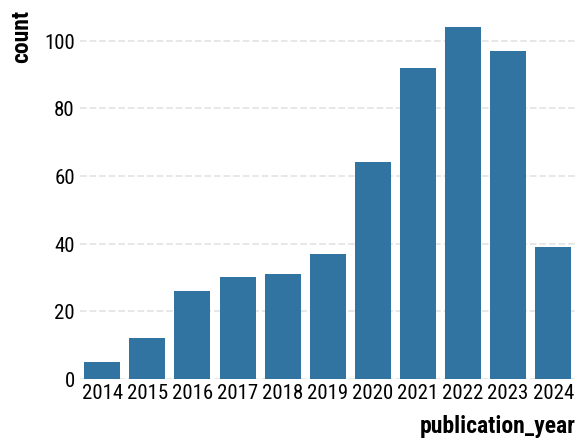

In [25]:
# plot count of papers by year
data["publication_date"] = pd.to_datetime(data["publication_date"])
data["publication_year"] = data["publication_date"].dt.year
sns.countplot(data=data, x="publication_year")